In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import explain.compute_importance as compute_importance
from deeplift.visualization import viz_sequence
import numpy as np
import pandas as pd
import json
import torch

### Define paths for the model and data of interest

In [3]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/HepG2/HepG2_training_paths.json"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 2
use_controls = False
model_class = profile_models.ProfilePredictorWithoutControls

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
# Import the model
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Import the model with priors
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/HepG2_prior/1/model_ckpt_epoch_10.pt"
model = model_util.restore_model(model_class, model_path)
model.eval()
model = model.to(device)

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [7]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

### Compute SHAP scores

In [8]:
num_samples = 5
rng = np.random.RandomState(20200115)
pos_sample = pos_coords_table.sample(num_samples, random_state=rng).values[:, :3]
input_seqs, profs = coords_to_network_inputs(pos_sample)
cont_profs = profs[:, num_tasks:, :, :]

In [9]:
prof_explainer = compute_importance.create_explainer(
    model, input_length, profile_length, num_tasks, output_type="profile", use_controls=use_controls
)
prof_scores = prof_explainer(input_seqs, cont_profs)

In [10]:
count_explainer = compute_importance.create_explainer(
    model, input_length, profile_length, num_tasks, output_type="count", use_controls=use_controls
)
count_scores = count_explainer(input_seqs, cont_profs)

Random peak 1


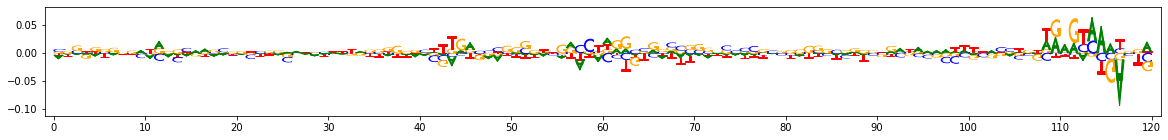

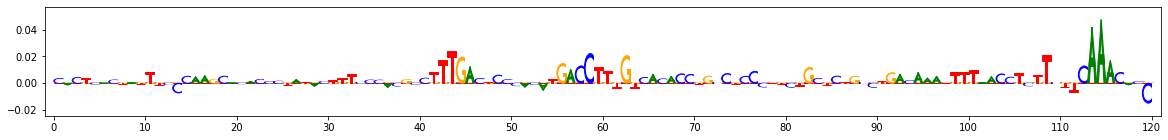

Random peak 2


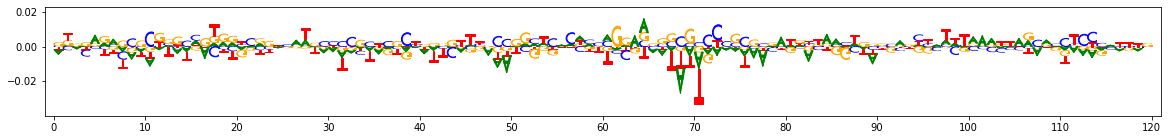

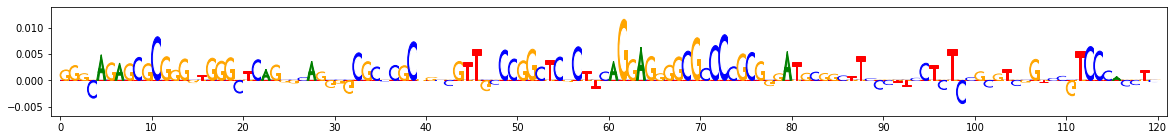

Random peak 3


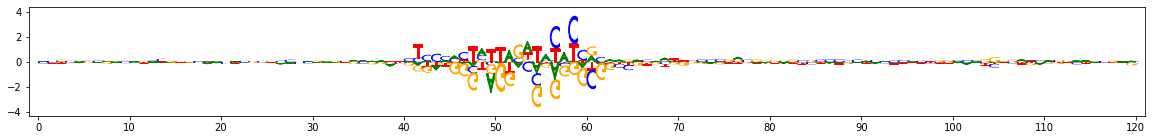

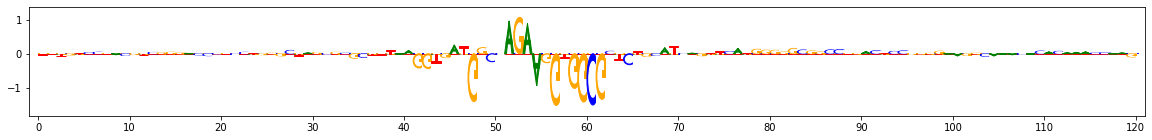

Random peak 4


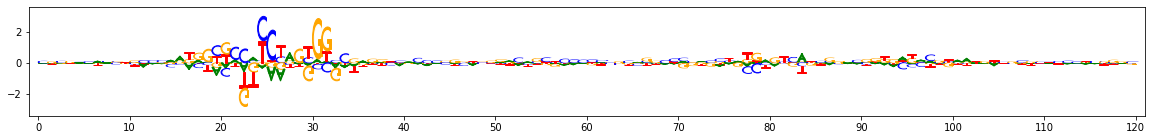

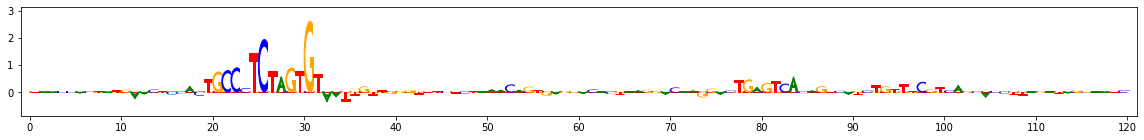

Random peak 5


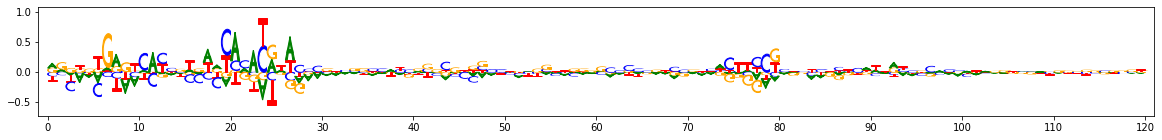

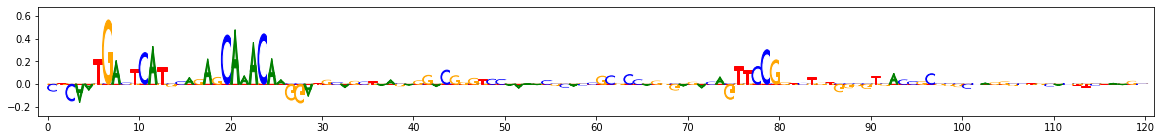

In [11]:
# Plot hypothetical and actual DeepLIFT/SHAP scores derived from profile output
central_slice = slice((input_length // 2) - 60, (input_length // 2) + 60)
for i in range(num_samples):
    print("Random peak %d" % (i + 1))
    viz_sequence.plot_weights(prof_scores[i][central_slice], subticks_frequency=10)
    viz_sequence.plot_weights(prof_scores[i][central_slice] * input_seqs[i][central_slice], subticks_frequency=10)

Random peak 1


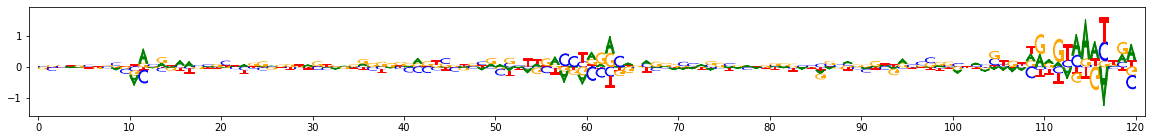

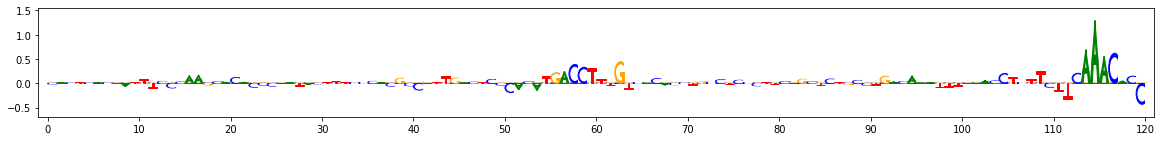

Random peak 2


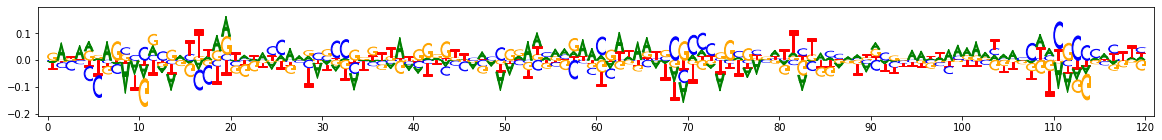

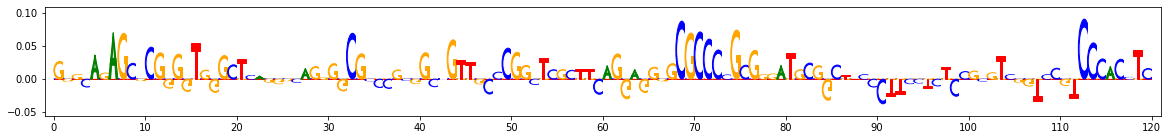

Random peak 3


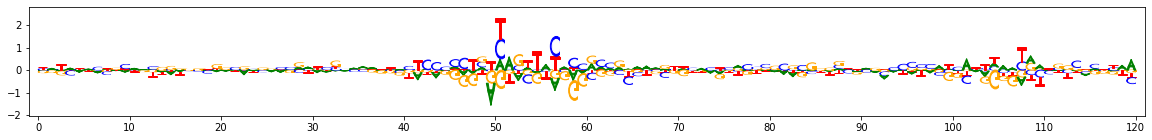

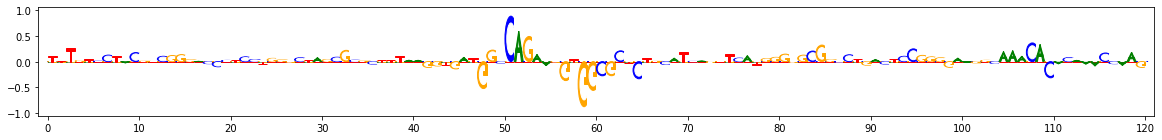

Random peak 4


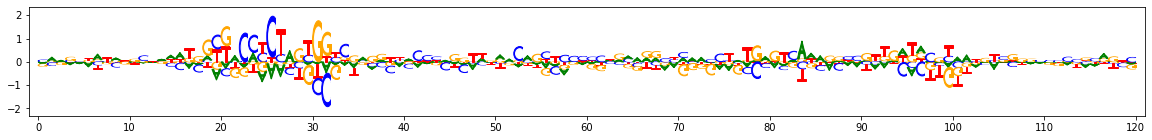

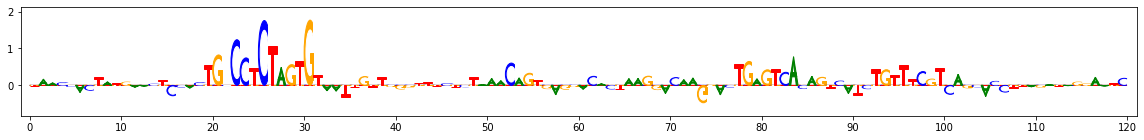

Random peak 5


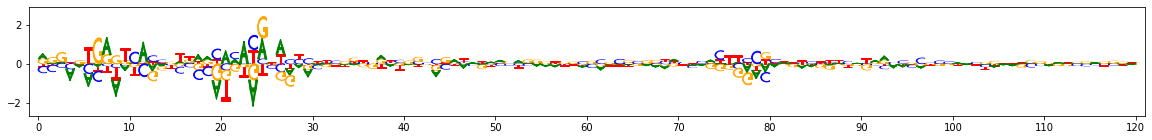

In [ ]:
# Plot hypothetical and actual DeepLIFT/SHAP scores derived from count output
central_slice = slice((input_length // 2) - 60, (input_length // 2) + 60)
for i in range(num_samples):
    print("Random peak %d" % (i + 1))
    viz_sequence.plot_weights(count_scores[i][central_slice], subticks_frequency=10)
    viz_sequence.plot_weights(count_scores[i][central_slice] * input_seqs[i][central_slice], subticks_frequency=10)